### Game

1. In Liars Game, a community of $n$ players start with the same amount of money each.
2. Every round each individual selects how much they want to contribute to the central pot.
3. After each round the central point is distributed between the entire community.
4. The community does not like selfish people, so they kick out the person who gives the least amount of money each round.
5. This also means that if you give too much in the beginning, you will not have enough in the end to survive.
6. What strategy increases the odds of you coming out victorious?

### Getting started

There's a cell below titled *Your Custom Player*. Make the improvements you want to it, uncomment your player from the strategies list, and then run the entire notebook :)

### Links
- GitRepo: https://github.com/migueltorrescosta/nash_equilibria/tree/main/tournments/liars_game

### Remark
- The Uniformly Random function might not perform very well, but for now it is the only one introducing a significant amount of randomness. Without it the other strategies become deterministic and provide for a very boring analysis
- In a game where all opponents always put everything, then you are limited to do the same. However as soon as someone else has a different strategy, you can beat it by putting slightly more and then always putting almost everything.

### Current Best Strategies:

1. Slightly More
2. Exponential Decay
3. Two Over N Players
4. Everything
5. Everything Except First Round
6. Ninety Percentile
7. Half
8. Uniformly Random
9. Tenth Percentile

(ordered by average number of rounds survived. Descriptions and more details below)

### All imports

In [1]:
import random
import pandas as pd
from abc import abstractmethod
import seaborn as sns
from tqdm import tqdm
import itertools

cm = sns.light_palette("green", as_cmap=True)

### Game Class

In [2]:
class LiarsGame:
    def __init__(self, strategies, verbose=False):

        assert len(strategies) > 2, "You need at least 3 players to start a game"

        # Secret attributes
        self.__players = [strategy(name=strategy.__name__) for strategy in strategies]
        self.__initial_n_players = len(self.__players)
        self.__money = {player: 100 for player in self.__players}
        self.__game_history = pd.DataFrame(
            columns=[player.name for player in self.__players], index=[], data=0
        )
        self.__verbose = verbose
        self.__eliminations = []
        self.__run_game()

    def __repr__(self):
        return f"LiarsGame: {self.n_players} with {self.total_money}¥"

    def __weight(self, coin_list):
        return sum([self.__coin_weights[i] for i in coin_list])

    # Accessible attributes
    @property
    def money(self):
        return self.__money

    @property
    def total_money(self):
        return sum(self.__money.values())

    @property
    def players(self):
        return self.__players

    @property
    def n_players(self):
        return len(self.__players)

    @property
    def eliminations(self):
        return self.__eliminations

    @property
    def game_history(self):
        return self.__game_history

    def show_game_history_heatmap(self):
        return (
            self.__game_history.T.style.background_gradient(cmap=cm)
            .set_precision(2)
            .highlight_null("red")
        )

    def show_game_history_bar_plot(self):
        return self.__game_history.plot.bar(
            stacked=True, figsize=(20, 10), width=0.95
        ).legend(loc="center right", bbox_to_anchor=(0, 0.5), prop={"size": 18})

    def my_money(self, player):
        return self.__money[player]

    # Key Methods

    def __run_round(self):

        self.__game_history.loc[self.__initial_n_players - self.n_players] = {
            player.name: self.money[player] for player in self.players
        }

        current_move = {
            player: max([min([player.move(self), 1]), 0]) * self.money[player]
            for player in self.players
        }

        if self.__verbose:
            for player in self.players:
                print(
                    f"{player.name}: {current_move[player]:.2f} / {self.money[player]:.2f}"
                )
            print("\n" + "=" * 50 + "\n")

        lowest_contribution = min(current_move.values())
        smallest_contributor = random.choice(
            [
                player
                for player in self.__players
                if current_move[player] == lowest_contribution
            ]
        )
        self.__eliminations.append(smallest_contributor)
        current_move[smallest_contributor] = self.__money[smallest_contributor]
        pot = sum(current_move.values())
        self.__players = [
            player for player in self.__players if player != smallest_contributor
        ]
        self.__money = {
            player: self.__money[player] - current_move[player] + pot / self.n_players
            for player in self.players
        }

    def __run_game(self):
        while self.n_players > 1:
            self.__run_round()

        winner = self.players[0]
        self.__game_history.loc[self.__initial_n_players - self.n_players] = {
            winner.name: self.money[winner]
        }
        self.__eliminations.append(winner)
        if self.__verbose:
            print(f"Winner: {winner.name}")

        return winner.name

### Player Parent Class

In [3]:
class Player:

    def __init__(self, name):
        self.name = name

    def __repr__(self):
        return self.name

    @abstractmethod
    def move(self):
        pass

### Submitted Strategies

In [4]:
# Always contributes half of their wealth
class half(Player):
    def move(self, status):
        return 0.5


# Always contributes all their wealth


class everything(Player):
    def move(self, status):
        return 1


# Always contributes 90% of their wealth


class ninety_percentile(Player):
    def move(self, status):
        return 0.9


# Always contributes 10% of their wealth


class tenth_percentile(Player):
    def move(self, status):
        return 0.1


# Contributes an uniformly random amount of their wealth


class uniformly_random(Player):
    def move(self, status):
        return random.random()


# Contributes a weird amount


class two_over_n_players(Player):

    def __init__(self, name):
        self.name = name
        self.initial_number_of_players = None

    def move(self, status):
        if not self.initial_number_of_players:
            self.initial_number_of_players = status.n_players
        return 1 - (status.n_players - 2) / self.initial_number_of_players


# In the first random it contributes a random amount, otherwise it contributes everything


class everything_except_first_round(Player):

    def __init__(self, name):
        self.name = name
        self.is_first_move = True

    def move(self, status):
        if self.is_first_move:
            self.is_first_move = False
            return random.random()
        else:
            return 1


# Contributes an amount that converges to 1 exponentially


class exponential_decay(Player):

    def __init__(self, name):
        self.name = name
        self.initial_number_of_players = None

    def move(self, status):

        if not self.initial_number_of_players:
            self.initial_number_of_players = status.n_players

        return 1 - 0.3 ** (1 + self.initial_number_of_players - status.n_players)


# First round it contributes an uniformly random amount, after that it contributes the minimum needed to ensure survival.


class slightly_more(Player):

    def __init__(self, name):
        self.name = name
        self.is_first_move = True

    def move(self, status):
        if self.is_first_move:
            self.is_first_move = False
            return random.random()
        if status.n_players == 2:
            return 1
        else:
            least_money = min(status.money.values())
            return least_money / status.my_money(self) + 10e-9


class slightly_less(Player):

    def __init__(self, name):
        self.name = name
        self.is_first_move = True

    def move(self, status):
        least_money = min(status.money.values())
        if self.is_first_move:
            self.is_first_move = False
            return random.random()
        if status.n_players == 2:
            return 1
        else:
            least_money = min(status.money.values())
            return least_money - 10e-9


class hrna_ox(Player):
    def __init__(self, name, num_risk_rounds=2, risk_min_frac=0.4, risk_bias=0.1):
        self.name = name
        self.risk_rounds = num_risk_rounds
        self.risk_min_frac = risk_min_frac
        self.risk_bias = risk_bias
        self.current_round = 1

    def move(self, status):
        # For the first risk_rounds, adopt an agressive, risky strategy based on fraction of the minimum with bias. Otherwise, minimum
        min_money = min(status.money.values())
        if self.current_round <= self.risk_rounds:
            # Risky bet!
            bet = min_money * (self.risk_bias + self.risk_min_frac * random.random())
            self.current_round += 1

        else:
            bet = min_money + 1e-9

        return bet

### Your playground

Edit the code below with your own ideas :)

In [5]:
class your_custom_player(Player):

    def __init__(self, name):
        self.name = name
        self.is_first_move = True

    def move(self, status):
        if self.is_first_move:
            self.is_first_move = False
            return random.random() * 0.9 + 0.1
        if status.n_players == 2:
            return 1
        else:
            least_money = min(status.money.values())
            return least_money / status.my_money(self) + 10e-9

# Setup variables

In [6]:
best_strategies = [
    exponential_decay,
    half,
    everything,
    #    tenth_percentile,
    ninety_percentile,
    two_over_n_players,
    uniformly_random,
    everything_except_first_round,
    slightly_more,
    slightly_less,
    your_custom_player,
    hrna_ox,
]

# Sample Run

In [7]:
x = LiarsGame(strategies=best_strategies)
x.show_game_history_heatmap()

,0,1,2,3,4,5,6,7,8,9,10
exponential_decay,100.00,108.82,107.26,125.73,152.84,179.83,215.53,269.32,359.06,nan,nan
half,100.00,128.82,161.88,203.77,nan,nan,nan,nan,nan,nan,nan
everything,100.00,78.82,97.47,122.83,151.83,179.46,215.40,269.27,nan,nan,nan
ninety_percentile,100.00,88.82,106.35,133.47,165.17,nan,nan,nan,nan,nan,nan
two_over_n_players,100.00,160.64,214.30,nan,nan,nan,nan,nan,nan,nan,nan
uniformly_random,100.00,137.50,nan,nan,nan,nan,nan,nan,nan,nan,nan
everything_except_first_round,100.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
slightly_more,100.00,96.35,114.99,140.36,169.35,196.98,232.92,286.80,376.56,556.09,1100.00
slightly_less,100.00,137.23,97.47,122.83,151.83,179.46,215.40,nan,nan,nan,nan
your_custom_player,100.00,84.16,102.80,128.17,157.16,184.80,220.74,274.61,364.38,543.91,nan


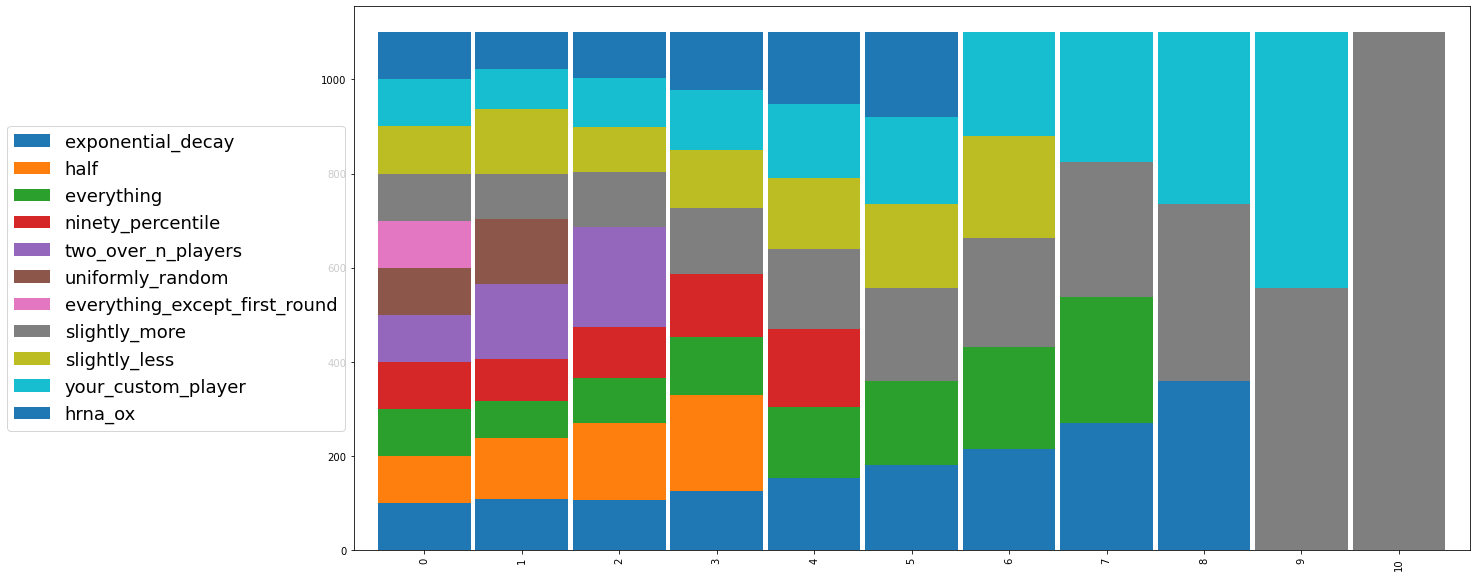

In [8]:
x.show_game_history_bar_plot()

# Distribution of Rounds survived

The more rounds one survives, the better the strategy is

100%|██████████| 100000/100000 [1:09:32<00:00, 23.97it/s]


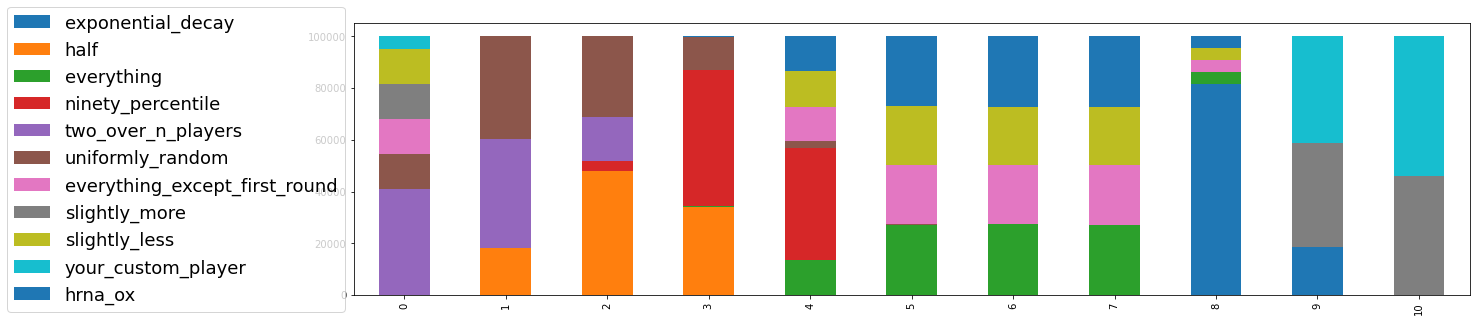

In [9]:
runs = int(10e4)
strategy_names = [strategy.__name__ for strategy in best_strategies]
rounds_survived = pd.DataFrame(
    columns=range(len(strategy_names)), index=strategy_names, data=0
)

for _ in tqdm(range(runs)):
    eliminations = LiarsGame(strategies=best_strategies).eliminations
    for i, player in enumerate(eliminations):
        rounds_survived[i][player.name] += 1

rounds_survived.T.plot.bar(stacked=True, figsize=(20, 5), width=0.5).legend(
    loc="center right", bbox_to_anchor=(0, 0.5), prop={"size": 18}
)

In [10]:
average_survival = {
    name: rounds_survived.loc[name].dot(rounds_survived.columns)
    / (runs * (len(best_strategies) - 1))
    for name in strategy_names
}
rounds_survived["mean"] = rounds_survived.index.map(average_survival)
rounds_survived = rounds_survived.sort_values(by="mean", ascending=False)

print(f"Results from {runs} runs")
rounds_survived.style.background_gradient(cmap=cm)

Results from 100000 runs


,0,1,2,3,4,5,6,7,8,9,10,mean
your_custom_player,4896,0,0,0,0,0,0,0,9,41217,53878,0.909805
slightly_more,13540,0,0,0,0,0,0,0,8,40331,46121,0.824253
exponential_decay,0,0,0,0,0,0,0,0,81547,18452,1,0.818454
hrna_ox,0,0,0,150,13598,27072,27180,27410,4590,0,0,0.581872
everything,0,0,0,159,13593,27169,27363,27045,4671,0,0,0.581555
everything_except_first_round,13580,0,0,142,13365,22623,22671,23056,4563,0,0,0.500923
slightly_less,13595,0,0,141,13631,22780,22753,22488,4612,0,0,0.499677
ninety_percentile,0,0,4121,52721,43158,0,0,0,0,0,0,0.339037
half,0,18115,47770,34115,0,0,0,0,0,0,0,0.216000
uniformly_random,13525,39748,31110,12572,2655,356,33,1,0,0,0,0.152289


# Online Play

You can use this section to play directly against the above strategies

In [11]:
import pprint

pp = pprint.PrettyPrinter()


class online_player(Player):

    def move(self, status):
        pp.pprint(status.money)
        x = float(input())
        return x / status.my_money(self)

In [ ]:
best_strategies.append(online_player)

x = LiarsGame(strategies=best_strategies)
x.show_game_history_heatmap()

{everything: 100,
 everything_except_first_round: 100,
 exponential_decay: 100,
 half: 100,
 hrna_ox: 100,
 ninety_percentile: 100,
 online_player: 100,
 slightly_less: 100,
 slightly_more: 100,
 two_over_n_players: 100,
 uniformly_random: 100,
 your_custom_player: 100}
